In [1]:
import pandas as pd
import tushare as ts
import os
import sys
import time
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
%%time

hs300_list = list(ts.get_hs300s()['code'])
# print(hs300_list)

CPU times: user 139 ms, sys: 6 ms, total: 145 ms
Wall time: 1.97 s


In [3]:
os.getcwd()
# for symbol in hs300_list[:]:
for symbol in ['399300']:
    df = ts.get_k_data(code=symbol, index=True, start='2008-01-01', end='2018-08-01')
#     df = ts.get_k_data(code=symbol, ktype='D', autype='qfq', index=False, start='2008-01-01', end='2018-08-01')
    datafile = '../database/market/%s.csv' % symbol
    df.to_csv(datafile, index=False, encoding='utf-8')
    print(datafile)
    time.sleep(1)

'/home/chronos/user/Downloads/Coding/ML4M/notebook'

../database/market/399300.csv


In [4]:
%%time

stock_df_dict = {}

for symbol in hs300_list + ['399300']:
    stock_data_file = '../database/market/%s.csv' % symbol
    stock_df = pd.read_csv(stock_data_file)

    # 筛选字段
    stock_df = stock_df.loc[:, ['date', 'close']]

    # 抛弃空值异常值
    stock_df.dropna(axis=0, how='any', inplace=True)

    # 格式化日期，和news_df['publish_time']一致
    stock_df['date'] = stock_df['date'].apply(lambda x: pd.Period(x, freq='D'))

    # 转换字段格式
#     stock_df = stock_df.astype(dtype={'volume': 'float64'})

    # 用日期作索引，日期升序排序
    stock_df.set_index(['date'], inplace=True)
#     stock_df = stock_df.sort_index(axis=0, ascending=True)

    stock_df['pct_change'] = stock_df.close.pct_change(1)
    
#     stock_df = stock_df['2016-01-01':]
    
    stock_df_dict[symbol] = stock_df


CPU times: user 18min 26s, sys: 18.7 s, total: 18min 44s
Wall time: 19min 7s


In [5]:
stock_df_dict['000983'].loc['2008-04-10']

close         16.303000
pct_change     0.033274
Name: 2008-04-10, dtype: float64

In [6]:
show_df = None
show_df = stock_df_dict['399300'].copy()

In [13]:
%%time

### Turtle

PROPERTY = 100000
CASH = 100000
HAPPY_MONEY = 0
hold = []
recode_df = pd.DataFrame(columns=['date', 'ops', 'reason', 'symbol', 'count', 'price', 'buy_price', 'expect', 'profit', 'cash', 'property'])

start_date = '2008-01-02'
start_date = '2015-01-01'
# start_date = '2017-01-03'
# start_date = '2017-06-27'
end_date = '2018-04-27'
# end_date = '2017-12-31'

yesterday = None


show_df['CASH_T'] = pd.np.nan
show_df['PROPERTY_T'] = pd.np.nan
show_df['HAPPY_MONEY_T'] = 0


N = 60
M = 60
N_rolling_max_df_dict = {}
M_rolling_min_df_dict = {}

for symbol in hs300_list:
    N_rolling_max_df_dict[symbol] = stock_df_dict[symbol].loc[:, 'close'].rolling(N).max()
    M_rolling_min_df_dict[symbol] = stock_df_dict[symbol].loc[:, 'close'].rolling(M).min()


for today in pd.period_range(start=start_date, end=end_date, freq='D'):
#     print(today, 'START')

    if today not in stock_df_dict['399300'].index:
#         print(today, 'not in index')
        continue

    if yesterday is None:
        yesterday = today
#         print(today, 'continue')
        continue

    
    if PROPERTY > 100000 * 11.5:
        hold = []
        HAPPY_MONEY += 20000
        PROPERTY -= 20000
        CASH = PROPERTY
        show_df.loc[today, 'HAPPY_MONEY'] = HAPPY_MONEY


    for order in hold:
        if today not in stock_df_dict[order[1]].index:
            continue
#         print(order)

        try:
            is_sell = (stock_df_dict[order[1]].loc[today, 'close'] == M_rolling_min_df_dict[order[1]].loc[today])
        except:
            print(stock_df_dict[order[1]].loc[:, 'close'].rolling(N).min())
            raise 'FUCK'
#         print(is_sell)
        
        if is_sell:
            hold.remove(order)
            CASH += stock_df_dict[order[1]].loc[today, 'close'] * order[2]
#             print('%s 退出 SELL %s * %d @ %f' % (today, order[1], order[2], stock_df_dict[order[1]].loc[today, 'close']))
            recode_df = recode_df.append(
                {
                    'date': today,
                    'ops': 'SELL',
                    'reason': 'WIN',
                    'symbol': order[1],
                    'count': order[2],
                    'price': stock_df_dict[order[1]].loc[today, 'close'],
                    'buy_price': order[3],
                    'expect': order[4],
                    'profit': (stock_df_dict[order[1]].loc[today, 'close'] - order[3]) * order[2],
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
    
    for symbol in hs300_list:
        if today not in stock_df_dict[symbol].index:
#             print(symbol, today, 'FUCK1')
            continue
        try:
            # turtle buy N days
            is_buy = (stock_df_dict[symbol].loc[today, 'close'] == N_rolling_max_df_dict[symbol].loc[today])

            if is_buy:
                if CASH < 100000 / 20:
                    continue
                buy = int(100000 / 20 / stock_df_dict[symbol].loc[today, 'close'])
                if buy == 0:
                    continue
                CASH -= stock_df_dict[symbol].loc[today, 'close'] * buy
#                 hold.append([today, symbol, buy, stock_df_dict[symbol].loc[today, 'close'], stock_df_dict[symbol].loc[yesterday, 'close']])
                hold.append([today, symbol, buy, stock_df_dict[symbol].loc[today, 'close'], 0])
#                 print('%s 进场 BUY  %s * %d @ %f EXPECT %f' % (today, symbol, buy, stock_df_dict[symbol].loc[today, 'close'], 0))
                recode_df = recode_df.append(
                    {
                        'date': today,
                        'ops': 'BUY',
                        'reason': 'ENTER',
                        'symbol': symbol,
                        'count': buy,
                        'price': stock_df_dict[symbol].loc[today, 'close'],
                        'buy_price': stock_df_dict[symbol].loc[today, 'close'],
    #                     'expect': stock_df_dict[symbol].loc[yesterday, 'close'],
                        'expect': 0,
                        'profit': 0,
                        'cash': CASH,
                        'property': PROPERTY,
                    },
                    ignore_index=True
                )
        except Exception as e:
            print(e)
            print(symbol, today, 'FUCK')
            raise 'FUCK'
    
    show_df.loc[today, 'CASH_T'] = CASH
    PROPERTY = CASH + sum([float(stock_df_dict[order[1]].loc[:today, 'close'].tail(1)) * order[2] for order in hold])
    show_df.loc[today, 'PROPERTY_T'] = PROPERTY

    yesterday = today
            

print(CASH)
print(HAPPY_MONEY)
print(PROPERTY)
print(hold)

s_p = stock_df_dict['399300'][start_date:].iloc[0].close
e_p = stock_df_dict['399300'].iloc[-1].close
print('399300', s_p, e_p, e_p / s_p)

3200.0630000000074
0
97120.306
[[Period('2016-12-27', 'D'), '600309', 293, 17.038, 0], [Period('2016-12-30', 'D'), '600809', 203, 24.601999999999997, 0], [Period('2017-04-18', 'D'), '600009', 144, 34.508, 0], [Period('2017-05-22', 'D'), '600009', 127, 39.35, 0], [Period('2017-10-31', 'D'), '600009', 114, 43.75, 0], [Period('2018-01-15', 'D'), '600028', 727, 6.877000000000001, 0], [Period('2018-03-19', 'D'), '600276', 75, 66.334, 0], [Period('2018-03-26', 'D'), '600372', 322, 15.487, 0], [Period('2018-03-26', 'D'), '600436', 58, 85.992, 0], [Period('2018-04-16', 'D'), '600570', 74, 67.014, 0], [Period('2018-04-16', 'D'), '601877', 187, 26.686, 0], [Period('2018-04-16', 'D'), '000503', 113, 44.11, 0], [Period('2018-04-18', 'D'), '600637', 281, 17.78, 0], [Period('2018-04-18', 'D'), '601877', 182, 27.355999999999998, 0], [Period('2018-04-18', 'D'), '000768', 260, 19.204, 0], [Period('2018-04-18', 'D'), '300059', 349, 14.31, 0]]
399300 3641.54 3447.39 0.9466846444086842
CPU times: user 7mi

In [8]:
recode_df
recode_df['']

,date,ops,reason,symbol,count,price,buy_price,expect,profit,cash,property
0,2017-01-04,BUY,ENTER,600038,99,50.020,50.020,0,0,95048.020,100000
1,2017-01-04,BUY,ENTER,600309,268,18.642,18.642,0,0,90051.964,100000
2,2017-01-04,BUY,ENTER,600339,657,7.610,7.610,0,0,85052.194,100000
3,2017-01-04,BUY,ENTER,600519,14,341.813,341.813,0,0,80266.812,100000
4,2017-01-04,BUY,ENTER,600809,194,25.772,25.772,0,0,75267.044,100000
5,2017-01-04,BUY,ENTER,601117,733,6.812,6.812,0,0,70273.848,100000
6,2017-01-04,BUY,ENTER,601333,958,5.214,5.214,0,0,65278.836,100000
7,2017-01-04,BUY,ENTER,000725,1638,3.051,3.051,0,0,60281.298,100000
8,2017-01-04,BUY,ENTER,000959,653,7.650,7.650,0,0,55285.848,100000
9,2017-01-05,BUY,ENTER,600028,963,5.188,5.188,0,0,50289.804,100000


In [9]:
%%time

### BT

PROPERTY = 100000
CASH = 100000
HAPPY_MONEY = 0
hold = []
recode_df = pd.DataFrame(columns=['date', 'ops', 'reason', 'symbol', 'count', 'price', 'buy_price', 'expect', 'profit', 'cash', 'property'])

start_date = '2008-01-02'
start_date = '2017-01-03'
# start_date = '2017-06-27'
end_date = '2018-04-27'
# end_date = '2017-12-31'

yesterday = None

# show_df = None
# show_df = stock_df_dict['399300'].copy()
show_df['CASH'] = pd.np.nan
show_df['PROPERTY'] = pd.np.nan
show_df['HAPPY_MONEY'] = 0

for today in pd.period_range(start=start_date, end=end_date, freq='D'):
#     print(today, 'START')

    if today not in stock_df_dict['399300'].index:
#         print(today, 'not in index')
        continue

    if yesterday is None:
        yesterday = today
#         print(today, 'continue')
        continue
    
    
    if PROPERTY > 100000 * 11.5:
        hold = []
        HAPPY_MONEY += 20000
        PROPERTY -= 20000
        CASH = PROPERTY
        show_df.loc[today, 'HAPPY_MONEY'] = HAPPY_MONEY


    show_df.loc[today, 'CASH'] = CASH
    PROPERTY = CASH
    # int(df.loc[:10].tail(1)['b'])
    for order in hold:
#         print(order)
        PROPERTY = PROPERTY + float(stock_df_dict[order[1]].loc[:today, 'close'].tail(1)) * order[2]
#     PROPERTY = CASH + sum([float(stock_df_dict[order[1]].loc[:today, 'close'].tail(1)) * order[2] for order in hold])
    show_df.loc[today, 'PROPERTY'] = PROPERTY

    for order in hold:
        if today not in stock_df_dict[order[1]].index:
            continue
#         print(order)
        
        is_sell_expect_rise = stock_df_dict[order[1]].loc[today, 'close'] > order[4]
        
        if is_sell_expect_rise:
            hold.remove(order)
            CASH += stock_df_dict[order[1]].loc[today, 'close'] * order[2]
#             print('%s win SELL %s * %d @ %f' % (today, order[1], order[2], stock_df_dict[order[1]].loc[today, 'close']))
            recode_df = recode_df.append(
                {
                    'date': today,
                    'ops': 'SELL',
                    'reason': 'WIN',
                    'symbol': order[1],
                    'count': order[2],
                    'price': stock_df_dict[order[1]].loc[today, 'close'],
                    'buy_price': order[3],
                    'expect': order[4],
                    'profit': (stock_df_dict[order[1]].loc[today, 'close'] - order[3]) * order[2],
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )

        elif stock_df_dict[order[1]].loc[today, 'close'] / order[4] < 0.75:
            hold.remove(order)
            CASH += stock_df_dict[order[1]].loc[today, 'close'] * order[2]
#             print('%s loss SELL %s * %d @ %f' % (today, order[1], order[2], stock_df_dict[order[1]].loc[today, 'close']))
            recode_df = recode_df.append(
                {
                    'date': today,
                    'ops': 'SELL',
                    'reason': 'LOSS',
                    'symbol': order[1],
                    'count': order[2],
                    'price': stock_df_dict[order[1]].loc[today, 'close'],
                    'buy_price': order[3],
                    'expect': order[4],
                    'profit': (stock_df_dict[order[1]].loc[today, 'close'] - order[3]) * order[2],
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )

        elif today - order[0] > 30:
            hold.remove(order)
            CASH += stock_df_dict[order[1]].loc[today, 'close'] * order[2]
#             print('%s TIMEUP SELL %s * %d @ %f' % (today, order[1], order[2], stock_df_dict[order[1]].loc[today, 'close']))
            recode_df = recode_df.append(
                {
                    'date': today,
                    'ops': 'SELL',
                    'reason': 'TIMEUP',
                    'symbol': order[1],
                    'count': order[2],
                    'price': stock_df_dict[order[1]].loc[today, 'close'],
                    'buy_price': order[3],
                    'expect': order[4],
                    'profit': (stock_df_dict[order[1]].loc[today, 'close'] - order[3]) * order[2],
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
    
    for symbol in hs300_list:
        if today not in stock_df_dict[symbol].index:
#             print(symbol, today, 'FUCK1')
            continue
        # buy drop wait rise back
        is_buy = (stock_df_dict[symbol].loc[today, 'pct_change'] < -0.05)
           
        if is_buy:
            if stock_df_dict[symbol].loc[today, 'close'] < stock_df_dict[symbol].shift(7).loc[today, 'close']:
                continue
            if CASH < 100000 / 20:
                continue
            buy = int(100000 / 20 / stock_df_dict[symbol].loc[today, 'close'])
#             buy = int(PROPERTY / 2 / stock_df_dict[symbol].loc[today, 'close'])
            CASH -= stock_df_dict[symbol].loc[today, 'close'] * buy
            hold.append([today, symbol, buy, stock_df_dict[symbol].loc[today, 'close'], float(stock_df_dict[order[1]].loc[:today, 'close'].tail(1))])
#             print('%s 进场 BUY  %s * %d @ %f EXPECT %f' % (today, symbol, buy, stock_df_dict[symbol].loc[today, 'close'], stock_df_dict[symbol].loc[yesterday, 'close']))
            recode_df = recode_df.append(
                {
                    'date': today,
                    'ops': 'BUY',
                    'reason': 'ENTER',
                    'symbol': symbol,
                    'count': buy,
                    'price': stock_df_dict[symbol].loc[today, 'close'],
                    'buy_price': stock_df_dict[symbol].loc[today, 'close'],
                    'expect': float(stock_df_dict[order[1]].loc[:today, 'close'].tail(1)),
                    'profit': 0,
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
    
    show_df.loc[today, 'CASH'] = CASH
    PROPERTY = CASH + sum([float(stock_df_dict[order[1]].loc[:today, 'close'].tail(1)) * order[2] for order in hold])
    show_df.loc[today, 'PROPERTY'] = PROPERTY

    yesterday = today
            

print(CASH)
print(HAPPY_MONEY)
print(PROPERTY)
print(hold)

s_p = stock_df_dict['399300'][start_date:].iloc[0].close
e_p = stock_df_dict['399300'].iloc[-1].close
print('399300', s_p, e_p, e_p / s_p)


95435.83700000006
0
100354.04900000006
[[Period('2018-04-27', 'D'), '603160', 52, 94.581, 44.08]]
399300 3342.23 3447.39 1.0314640225238838
CPU times: user 2min 49s, sys: 881 ms, total: 2min 50s
Wall time: 3min 12s


In [10]:
%%time

### Date Range
start_date = '2008-01-02'
start_date = '2017-01-03'
# start_date = '2017-06-27'
end_date = '2018-04-27'
# end_date = '2017-12-31'

### Turtle + BT
TURTLE_POS = 20
TURTLE_BUY_N = 60
TURTLE_SELL_N = 60

is_happy_money = False
START_MONEY = 100000
HAPPY_MONEY = 0
PROPERTY = START_MONEY
CASH = START_MONEY
hold = []
order_df_TB = pd.DataFrame(
    columns=['buy_date', 'strategy', 'symbol', 'buy_count', 'buy_price', 'expect', 'sell_date', 'sell_price', 'profit', 'cash', 'property']
)
count_day = 0
yesterday = None

# show_df['CASH_T'] = pd.np.nan
# show_df['PROPERTY_T'] = pd.np.nan

rolling_min_dict = {}
rolling_max_dict = {}

for symbol in hs300_list:
    rolling_min_dict[symbol] = stock_df_dict[symbol].loc[:, 'close'].rolling(TURTLE_SELL_N).min()
    rolling_max_dict[symbol] = stock_df_dict[symbol].loc[:, 'close'].rolling(TURTLE_BUY_N).max()
    

for today in pd.period_range(start=start_date, end=end_date, freq='D'):
# for today in stock_df_dict['NDX'].index:
    count_day += 1
    
    if yesterday is None:
        yesterday = today
        continue

    if today not in stock_df_dict['399300'].index:
        continue

    if is_happy_money:        
        if PROPERTY > 100000 * 2:
            hold = []
            HAPPY_MONEY += 50000
            PROPERTY -= 50000
            CASH = PROPERTY
    
    for idx in order_df_TB.index:
        order = order_df_TB.iloc[idx]
        
        if today not in stock_df_dict[order['symbol']].index:
            continue
        
        if order['sell_price'] != 0:
            continue
        
        if order['strategy'] == 'TURTLE':
            is_sell = stock_df_dict[order['symbol']].loc[today, 'close'] == rolling_min_dict[order['symbol']].loc[today]
        elif order['strategy'] == 'BT':
            is_sell = stock_df_dict[order['symbol']].loc[today, 'close'] > order['expect']
            is_sell = is_sell or stock_df_dict[order['symbol']].loc[today, 'close'] / order['buy_price'] < 0.8
            is_sell = is_sell or today - order['buy_date'] > 30
        
        if is_sell:
            CASH += stock_df_dict[order['symbol']].loc[today, 'close'] * order['buy_count']
#             print('%s 售出 %s SELL %s * %d @ %f CASH=%d PROPERTY=%d' 
#                   % (today, order['strategy'], order['symbol'], order['buy_count'], stock_df_dict[order['symbol']].loc[today, 'open'], CASH, PROPERTY))
            order_df_TB.loc[idx, 'sell_date'] = today
            order_df_TB.loc[idx, 'sell_price'] = stock_df_dict[order['symbol']].loc[today, 'close']
            order_df_TB.loc[idx, 'profit'] = \
                (order_df_TB.loc[idx, 'sell_price'] - order_df_TB.loc[idx, 'buy_price']) * order_df_TB.loc[idx, 'buy_count']
    
    for symbol in hs300_list:
        if symbol == '399300':
            continue
        
        if today not in stock_df_dict[symbol].index:
            continue
        
        if count_day < 20:
            continue
        
        is_buy = False
        
        if not is_buy:
            is_buy = (stock_df_dict[symbol].loc[today, 'close'] == rolling_max_dict[symbol].loc[today])
            if is_buy:
                strategy = 'TURTLE'

        if not is_buy:
            is_buy = (stock_df_dict[symbol].loc[today, 'pct_change'] < -0.05)
            if is_buy:
                strategy = 'BT'
        
        if is_buy:
            if CASH < START_MONEY / TURTLE_POS:
                continue
            buy = int(START_MONEY / TURTLE_POS / stock_df_dict[symbol].loc[today, 'close'])
            if buy == 0:
                continue
            CASH -= stock_df_dict[symbol].loc[today, 'close'] * buy
#             print('%s 进场 %s BUY %s * %d @ %f CASH=%d PROPERTY=%d' % 
#                   (today, strategy, symbol, buy, stock_df_dict[symbol].loc[today, 'open'], CASH, PROPERTY))
            order_df_TB = order_df_TB.append(
                {
                    'buy_date': today,
                    'strategy': strategy,
                    'symbol': symbol,
                    'buy_count': buy,
                    'buy_price': stock_df_dict[symbol].loc[today, 'close'],
#                     'expect': stock_df_dict[symbol].loc[yesterday, 'close'],
                    'expect': stock_df_dict[symbol].shift(1).loc[today, 'close'],
                    'sell_date': pd.np.nan,
                    'sell_price': 0,
                    'profit': 0,
                    'cash': 0,
                    'property': 0,
                },
                ignore_index=True
            )
            
    show_df.loc[today, 'CASH_T+B'] = CASH
    PROPERTY = CASH + sum(
        [float(stock_df_dict[order_df_TB.loc[idx, 'symbol']].loc[:today, 'close'].tail(1)) * order_df_TB.loc[idx, 'buy_count'] \
             for idx in order_df_TB.loc[order_df_TB['sell_price']==0].index]
    )
    show_df.loc[today, 'PROPERTY_T+B'] = PROPERTY

    yesterday = today
            

print(CASH)
print(HAPPY_MONEY)
print(PROPERTY)
print(hold)

s_p = stock_df_dict['399300'][start_date:].iloc[0].close
e_p = stock_df_dict['399300'].iloc[-1].close
print('NDX', s_p, e_p, e_p / s_p)


2558.8160000000044
0
133411.44199999998
[]
NDX 3342.23 3447.39 1.0314640225238838
CPU times: user 5min 34s, sys: 1.4 s, total: 5min 36s
Wall time: 6min 5s


In [11]:
'len(order_df_TB)', len(order_df_TB)
turtle_df = order_df_TB.loc[order_df_TB['strategy']=='TURTLE'].copy()
bt_df = order_df_TB.loc[order_df_TB['strategy']=='TURTLE'].copy()
'len(turtle_df)', len(turtle_df)

'win money', sum(list(order_df_TB['profit']))
'year reward', (sum(list(order_df_TB['profit'])) / 100000 + 1) ** 0.1

'win rate', len(order_df_TB[order_df_TB.profit > 0]) / len(order_df_TB)
'win rate', len(turtle_df[turtle_df.profit > 0]) / len(turtle_df)
'win rate', len(bt_df[bt_df.profit > 0]) / len(bt_df)

('len(order_df_TB)', 81)

('len(turtle_df)', 58)

('win money', 17235.410999999993)

('year reward', 1.0160284784315234)

('win rate', 0.3333333333333333)

('win rate', 0.27586206896551724)

('win rate', 0.27586206896551724)

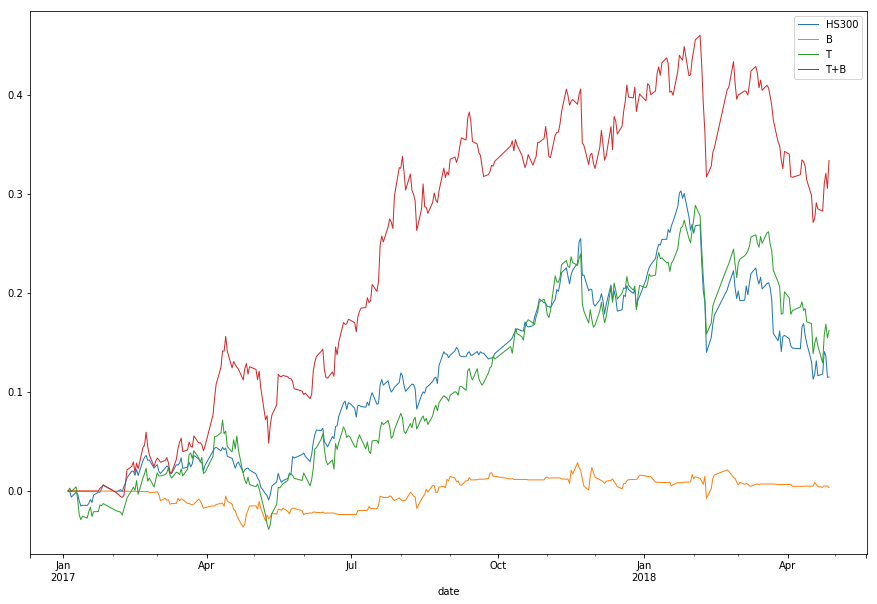

In [12]:
%matplotlib inline

import sys
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

df = show_df.dropna(how='any', inplace=False).copy()
df['close'] = (df['close'] - df.head(1)['close'].values) / df.head(1)['close'].values
df['PROPERTY'] = (df['PROPERTY'] - df.head(1)['PROPERTY'].values) / df.head(1)['PROPERTY'].values
df['PROPERTY_T'] = (df['PROPERTY_T'] - df.head(1)['PROPERTY_T'].values) / df.head(1)['PROPERTY_T'].values
df['PROPERTY_T+B'] = (df['PROPERTY_T+B'] - df.head(1)['PROPERTY_T+B'].values) / df.head(1)['PROPERTY_T+B'].values
# df['CASH'] = df['CASH'] / df.head(1)['CASH'].values
# stock_df_dict['NDX']

ax = df.plot(kind='line', y='close', label='HS300', linewidth=1)
ax = df.plot(kind='line', y='PROPERTY', secondary_y=False, label='B', linewidth=1, ax=ax)
ax = df.plot(kind='line', y='PROPERTY_T', label='T', secondary_y=False, linewidth=1, ax=ax)
ax = df.plot(kind='line', y='PROPERTY_T+B', label='T+B', secondary_y=False, linewidth=1, ax=ax)
# ax = df.plot(kind='line', y='HAPPY_MONEY', label='HAPPY_MONEY', secondary_y=True, ax=ax)
# ax = df.plot(kind='line', y='HAPPY_MONEY_T', label='HAPPY_MONEY_T', secondary_y=True, ax=ax)

# for symbol, stock_df in stock_df_dict.items():
#     df = stock_df.copy()
#     df['close'] = (df['close'] - df.head(1)['close'].values) / df.head(1)['close'].values
#     ax = df.plot(kind='line', y='close', secondary_y=False, label=symbol, linewidth=0.5, ax=ax)

# plt.figure(figsize=(10, 6), dpi=80)
# plt.show()